# Pretrained Models for Computer Vision

The goal of this notebook is get some hands-on experience with pre-trained Keras models that are reasonably close to the state of the art of some computer vision tasks. The models are pre-trained on large publicly available labeled images datasets such as [ImageNet](http://www.image-net.org/) and [COCO](http://cocodataset.org/).

This notebook highlights two specific tasks:

- **Image classification**: predict only one class label per-image (assuming a single centered object or image class)

- **Object detection and instance segmentation**: detect and localise all occurrences of objects of a predefined list of classes of interest in a given image.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Loading a JPEG file as a numpy array

Let's use [scikit-image](http://scikit-image.rg) to load the content of a JPEG file into a numpy array:

In [3]:
from skimage.io import imread

image = imread('laptop.jpeg')
type(image)

imageio.core.util.Image

The dimensions of the array are:
- height
- width
- color channels (RGB)

In [4]:
image.shape

(450, 800, 3)

For efficiency reasons, the pixel intensities of each channel are stored as **8-bit unsigned integer** taking values in the **[0-255] range**:

In [5]:
image.dtype

dtype('uint8')

In [6]:
image.min(), image.max()

(0, 255)

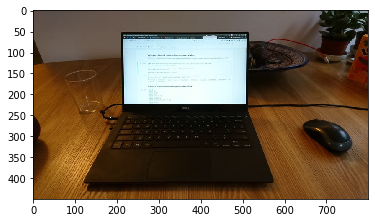

In [7]:
plt.imshow(image);

### Size of a numpy array

The size in bytes can be computed by multiplying the number of element by the size in byte of each element in the array.

The size of one element depend of the data type.

1 byte == 8 bits

A byte in English is an octet in French.

In [8]:
image.shape

(450, 800, 3)

In [9]:
np.product(image.shape)

1080000

In [10]:
image.dtype

dtype('uint8')

In [11]:
450 * 800 * 3 * (8 / 8)

1080000.0

Let's check by asking numpy:

In [12]:
image.nbytes

1080000

In [13]:
print("image size: {:0.3} MB".format(image.nbytes / 1e6))

image size: 1.08 MB


Indexing on the last dimension makes it possible to extract the 2D content of a specific color channel, for instance the red channel:

In [14]:
red_channel = image[:, :, 0]
red_channel

Image([[ 94,  93,  92, ..., 144,  86,  89],
       [ 95,  93,  92, ..., 153, 102,  75],
       [ 95,  94,  92, ..., 154, 104,  44],
       ...,
       [127, 133, 132, ..., 119, 124, 123],
       [128, 135, 126, ..., 119, 125, 126],
       [128, 134, 126, ..., 118, 125, 126]], dtype=uint8)

In [15]:
red_channel.min(), red_channel.max()

(0, 255)

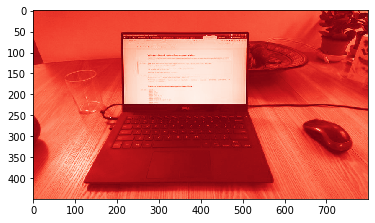

In [16]:
plt.imshow(image[:, :, 0], cmap=plt.cm.Reds_r);

### Exercise

- Compute a grey-level version of the image with shape `(height, width)` by averaging the values across color channels using [image.mean](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html).

- Plot the result with `plt.imshow` using a grey levels colormap.

- Can the uint8 integer data type represent those average values? Check the data type used by numpy.

- What is the size in (mega) bytes of this image? 

- What are the expected range of values for the new pixels?

In [ ]:
# %load solutions/grey_levels.py

## Resizing images, handling data types and dynamic ranges

When dealing with an heterogeneous collection of image of various sizes, it is often necessary to resize the image to the same size. More specifically:

- for **image classification**, most networks expect a specific **fixed input size**;

- for **object detection** and instance segmentation, networks have more flexibility but the image should have **approximately the same size as the training set images**.

Furthermore **large images can be much slower to process** than smaller images (the number of pixels varies quadratically with the height and width).

In [17]:
from skimage.transform import resize

image = imread('laptop.jpeg')
lowres_image = resize(image, (50, 50), mode='reflect', anti_aliasing=True)
lowres_image.shape

(50, 50, 3)

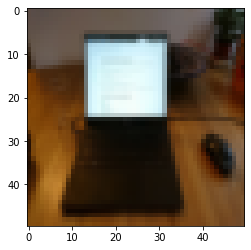

In [18]:
plt.imshow(lowres_image, interpolation='nearest');

The values of the pixels of the low resolution image are computed from by combining the values of the pixels in the high resolution image. The result is therefore represented as floating points. 

In [19]:
lowres_image.dtype

dtype('float64')

In [20]:
print("image size: {:0.3} MB".format(lowres_image.nbytes / 1e6))

image size: 0.06 MB


By conventions, both `skimage.transform.imresize` and `plt.imshow` assume that floating point values range from 0.0 to 1.0 when using floating points as opposed to 0 to 255 when using 8-bit integers:

In [21]:
lowres_image.min(), lowres_image.max()

(0.0, 0.996078431372549)

Note that keras on the other hand might expect images encoded with values in the `[0.0 - 255.0]` range irrespectively of the data type of the array. To avoid the implicit conversion to the `[0.0 - 1.0]` range we use the `preserve_range=True` option.

In [22]:
lowres_large_range_image = resize(image, (50, 50), mode='reflect',
                                  anti_aliasing=True, preserve_range=True)

In [23]:
lowres_large_range_image.shape

(50, 50, 3)

In [24]:
lowres_large_range_image.dtype

dtype('float64')

In [25]:
lowres_large_range_image.min(), lowres_large_range_image.max()

(0.0, 254.0)

**Warning:** the behavior of `plt.imshow` depends on both the dtype and the dynamic range when displaying RGB images. In particular it does not work on RGB images with float64 values in the `[0.0 - 255.0]` range:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


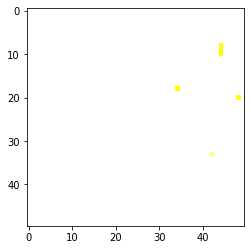

In [29]:
plt.imshow(lowres_large_range_image, interpolation='nearest');

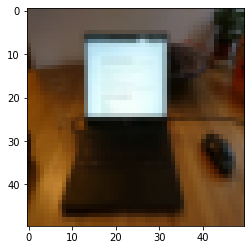

In [28]:
# L'image ci-dessus ne renvoie que quelques traits jaunes, il faut changer le range en divisant par 255 pour que Keras puisse interpréter entre 0 et 1
plt.imshow(lowres_large_range_image/255, interpolation='nearest');

### Question

Suggest two possible ways to correctly display an RGB array with floating point values in the `[0.0 - 255.0]` range:

In [ ]:
# %load solutions/question_imshow_dtype_and_range.py
plt.figure()
plt.imshow(lowres_large_range_image.astype(np.uint8), interpolation='nearest');
plt.figure()
plt.imshow(lowres_large_range_image / 255, interpolation='nearest');

##  Taking snapshots from the webcam

Let's use the [python API of OpenCV](pypi.python.org/pypi/opencv-python) to take pictures.

In [31]:
import cv2

def camera_grab(camera_id=0, fallback_filename=None):
    camera = cv2.VideoCapture(camera_id)
    try:
        # take 10 consecutive snapshots to let the camera automatically tune
        # itself and hope that the contrast and lightning of the last snapshot
        # is good enough.
        for i in range(10):
            snapshot_ok, image = camera.read()
        if snapshot_ok:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            print("WARNING: could not access camera")
            if fallback_filename:
                image = imread(fallback_filename)
    finally:
        camera.release()
    return image

dtype: uint8, shape: (480, 640, 3), range: (0, 255)


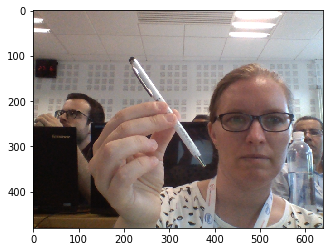

In [37]:
image = camera_grab(camera_id=0, fallback_filename='laptop.jpeg')
plt.imshow(image)
print("dtype: {}, shape: {}, range: {}".format(
    image.dtype, image.shape, (image.min(), image.max())))

## Image Classification


The Keras library includes several neural network model pretrained on the Image Net classification dataset. A popular model that shows a good tradeoff between computation speed, model size and accuracy is called ResNet-50:

In [38]:
from keras.applications.resnet50 import preprocess_input, ResNet50

model = ResNet50(weights='imagenet')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


Let's check that tensorflow backend used by Keras as the default backend expect the color channel on the last axis. If it had not been the case, it would have been possible to change the order of the axes with `images = images.transpose(2, 0, 1)`.

(Ici, le channel est en dernière pos ce qui est compatible avec scikit image et tensorflow)

In [39]:
import keras.backend as K

K.image_data_format()

'channels_last'

The network has been trained on (224, 224) RGB images.

In [41]:
# What is expected as a shape :
model.input_shape

(None, 224, 224, 3)

`None` is used by Keras to mark dimensions with a dynamic number of elements. In this case `None` is the "batch size", that is the number of images that can be processed at once. In the following we will process only one image at a time.

In [42]:
image = imread('laptop.jpeg')
image_224 = resize(image, (224, 224), preserve_range=True, mode='reflect')

In [43]:
image_224.shape

(224, 224, 3)

In [44]:
image_224.dtype

dtype('float64')

In [45]:
# l'image est en float64, ce qui est bcp, on peut le changer avec Keras car on a pas beosin d'une gde précision:
image_224 = image_224.astype(np.float32)
image_224.dtype

dtype('float32')

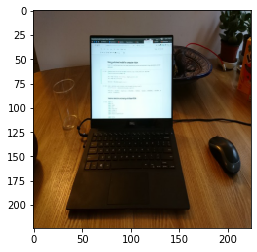

In [46]:
plt.imshow(image_224 / 255);

Ceci est l'image avec laquelle on va alimenter le neural network (conformément au shape recommandé plus haut)

Note that the image has been deformed by the resizing. In practice this should not degrade the performance of the network too much.

An alternative would be to:

- resize the image so that the smallest side is set to 224;
- extract a square centered crop of size (224, 224) from the resulting image.

In [47]:
model.input_shape

(None, 224, 224, 3)

In [48]:
image_224.shape

(224, 224, 3)

In [50]:
# on doit utiliser expand_dims sinon, on aura pas le batch (première valeur)
image_224_batch = np.expand_dims(image_224, axis=0)
# Or image_224_batch = image_224[None, ...] if you are familiar with broadcasting in numpy
image_224_batch.shape

(1, 224, 224, 3)

`image_224_batch` is now compatible with the input shape of the neural network, let's make a prediction.

In [51]:
%%time
x = preprocess_input(image_224_batch.copy())
preds = model.predict(x)

Wall time: 2.19 s


Image 224x244 sur un réseau de neurones de 5 layers = 2.19s de computing

The output predictions are a 2D array:

- 1 row per image in the batch,
- 1 column per target class in the ImageNet LSVRC dataset (1000 possible classes).

In [52]:
type(preds)

numpy.ndarray

In [53]:
preds.dtype

dtype('float32')

In [54]:
preds.shape

(1, 1000)

In [55]:
# 1000 is a probability (?)
# Si on sum
preds.sum(axis=1)

array([0.99999994], dtype=float32)

### Decoding the Prediction Probabilities

Reading the raw probabilities for the 1000 possible Image Net classes is tedious. Fortunately Keras comes with an helper function to extract the highest rated classes according to the model and display both the class names and the wordnet synset identifiers:

In [56]:
from keras.applications.resnet50 import decode_predictions

decode_predictions(preds, top=5)

40960/35363 [==================================] - 0s 0us/step


[[('n03832673', 'notebook', 0.3599505),
  ('n03642806', 'laptop', 0.25687215),
  ('n03179701', 'desk', 0.15139048),
  ('n03793489', 'mouse', 0.11147525),
  ('n03180011', 'desktop_computer', 0.051332064)]]

In [57]:
print('Predicted image labels:')
class_names, confidences = [], []
for class_id, class_name, confidence in decode_predictions(preds, top=5)[0]:
    print("    {} (synset: {}): {:0.3f}".format(class_name, class_id, confidence))

Predicted image labels:
    notebook (synset: n03832673): 0.360
    laptop (synset: n03642806): 0.257
    desk (synset: n03179701): 0.151
    mouse (synset: n03793489): 0.111
    desktop_computer (synset: n03180011): 0.051


Check on imagenet to better understand the use of the term "notebook" in the training set: http://image-net.org/search?q=notebook.

Note that the network in not too confident about the class of the main object in that image. If we were to merge the "notebook" and "laptop" classes, this prediction would be good.

Furthermore the network also considers secondary objects ("desk", "mouse"...) but the model as been trained as an image (multiclass) classification model with a single expected class per image rather than a multi-label classification model such as an object detection model with several positive labels per image.

We have to keep that in mind when trying to make use of the predictions of such a model for a practical application. This is a fundamental limitation of the label structure of the training set.

### A note on preprocessing

All Keras pretrained vision models expect images with float32 dtype and values in the [0, 255] range. When training neural network it often works better to have values closer to zero.

- A typical preprocessing is to center each the channel and normalize its variance.

- Another is to measure the min and max values and to shift and rescale to the `(-1.0, 1.0)` range.

The exact kind of preprocessing is not very important, but it's **very important to always reuse the preprocessing function that was used when training the model**.

In [58]:
image = imread('laptop.jpeg')
image_224 = resize(image, (224, 224), preserve_range=True, mode='reflect')
image_224_batch = np.expand_dims(image_224, axis=0)
image_224_batch.min(), image_224_batch.max()

(0.0, 255.0)

In [59]:
preprocessed_batch = preprocess_input(image_224_batch.copy())

In [60]:
preprocessed_batch.min(), preprocessed_batch.max()

(-121.21125, 151.061)

Note that we make a copy each time as `preprocess_input` can modify the image inplace to reuse memory when preprocessing large datasets.

### Exercise

- Write a function named `classify` that takes a snapshot of the webcam and displays it along with the decoded predictions of model and their confidence level.

- If you don't have access to a webcam take a picture with your mobile phone or a photo of your choice from the web, store it as a JPEG file on the disk instead and pass that file to the neural network to make the prediction.

- Try to classify a photo of your face. Look at the confidence level. Can you explain the results?

- Try to classify photos of common objects such as a book, a mobile phone, a cup... Try to center the objects and remove clutter to get confidence higher than 0.5.

In [ ]:
def classify():
    # TODO: write me
    pass

    
classify()

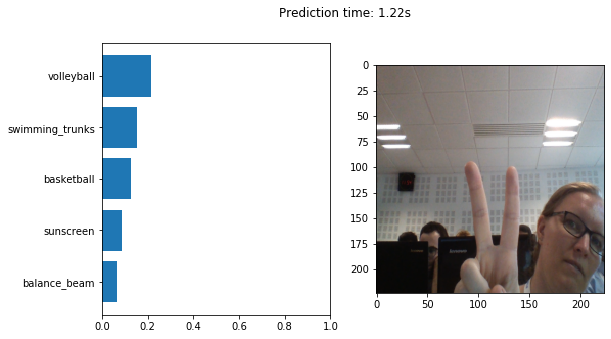

In [66]:
# %load solutions/classify_webcam.py
import time


def classify():
    image = camera_grab(camera_id=0, fallback_filename='laptop.jpeg')

    image = resize(image, (224, 224), preserve_range=True, mode='reflect')
    image_batch = np.expand_dims(image.astype(np.float32), axis=0)
    image_batch = preprocess_input(image_batch)

    tic = time.time()
    results = decode_predictions(model.predict(image_batch))[0]
    toc = time.time()

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
    classnames = [r[1] for r in reversed(results)]
    confidences = [r[2] for r in reversed(results)]
    pos = np.arange(len(classnames))

    ax0.barh(pos, confidences)
    ax0.set_yticks(pos)
    ax0.set_yticklabels(classnames)
    ax0.set_xlim(0, 1)
    ax1.imshow(image / 255)
    fig.suptitle("Prediction time: {:0.3}s".format(toc - tic))


classify()


### Home assignement #1

Use the "MobileNet" and "Inception Resnet v2" models from `keras.applications` instead of Resnet 50 to classify images from the webcam or stored as a JPEG file.

Read the documentation for more details on the expected input shape and preprocessing:

https://keras.io/applications/

Measure prediction time using `%%time` to compare to Resnet 50.


To time the execution of a notebook cell, you can use the `%%time` magic command. Here is an example:

In [ ]:
%%time

a = 0
for i in range(10000000):
    a += 1
print('Computation complete!')

In [ ]:
# %load solutions/inception_resnet_v2.py

## Instance Detection and Segmentation with Mask-RCNN


[Mask RCNN](https://arxiv.org/abs/1703.06870) is a refinement of the [Faster RCNN](https://arxiv.org/abs/1506.01497) **object detection** model to also add support for **instance segmentation**.

The following shows how to use a [Keras based implementation](https://github.com/matterport/Mask_RCNN) provided by matterport.com along with model parameters pretrained on the [COCO object detection dataset](http://cocodataset.org/).

**WARNING**: The following requires to execute the companion `data_download.ipynb` notebook first.

### Create Model and Load Trained Weights

In [67]:
from maskrcnn import config
from maskrcnn import model as modellib


class InferenceCocoConfig(config.Config):
    # Give the configuration a recognizable name
    NAME = "inference_coco"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 80  # COCO has 80 classes

    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


config = InferenceCocoConfig()
model = modellib.MaskRCNN(mode="inference", model_dir='maskrcnn/logs', config=config)

# Load weights trained on MS-COCO
coco_model_file = "mask_rcnn_coco.h5"
model.load_weights(coco_model_file, by_name=True)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


### Class Names

Index of the class in the list is its ID. For example, to get ID of the teddy bear class, use: `class_names.index('teddy bear')`

`BG` stands for background.

In [68]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

### Run Object Detection

In [69]:
from skimage.io import imread

image = imread('webcam_shot.jpeg')

In [70]:
image.shape

(480, 640, 3)

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
Analyzed image in 48.306s
person:	1.000
keyboard:	0.996
cell phone:	0.966
tv:	0.902
book:	0.900
chair:	0.841
dining table:	0.839


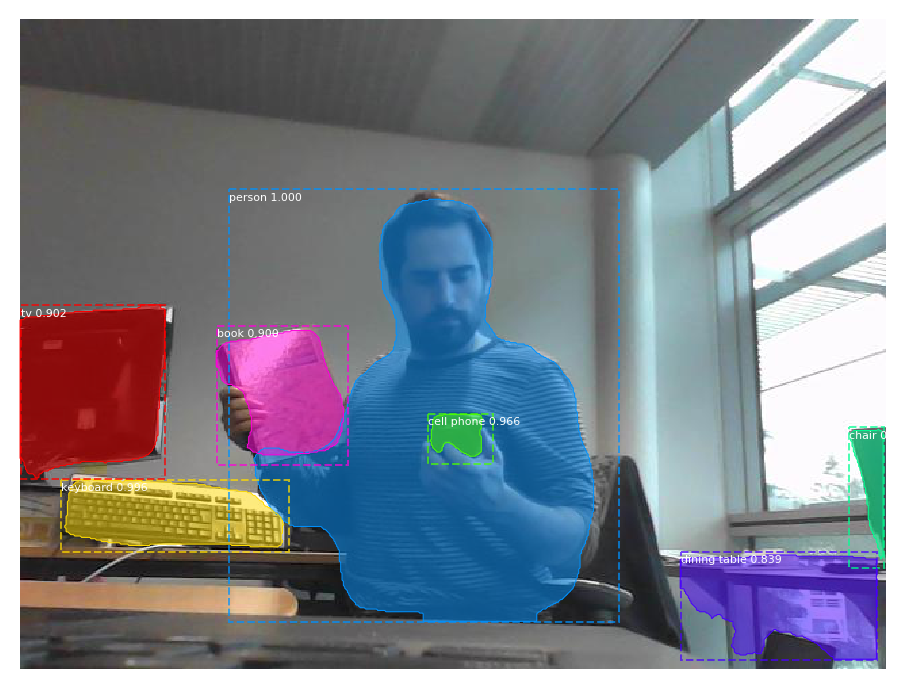

In [71]:
from maskrcnn import visualize
import time

# Run detection
tic = time.time()
results = model.detect([image], verbose=1)
toc = time.time()
print("Analyzed image in {:.3f}s".format(toc - tic))

# Visualize results
r = results[0]
for class_id, score in zip(r['class_ids'], r['scores']):
    print("{}:\t{:0.3f}".format(class_names[class_id], score))
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

Processing 1 images
image                    shape: (448, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


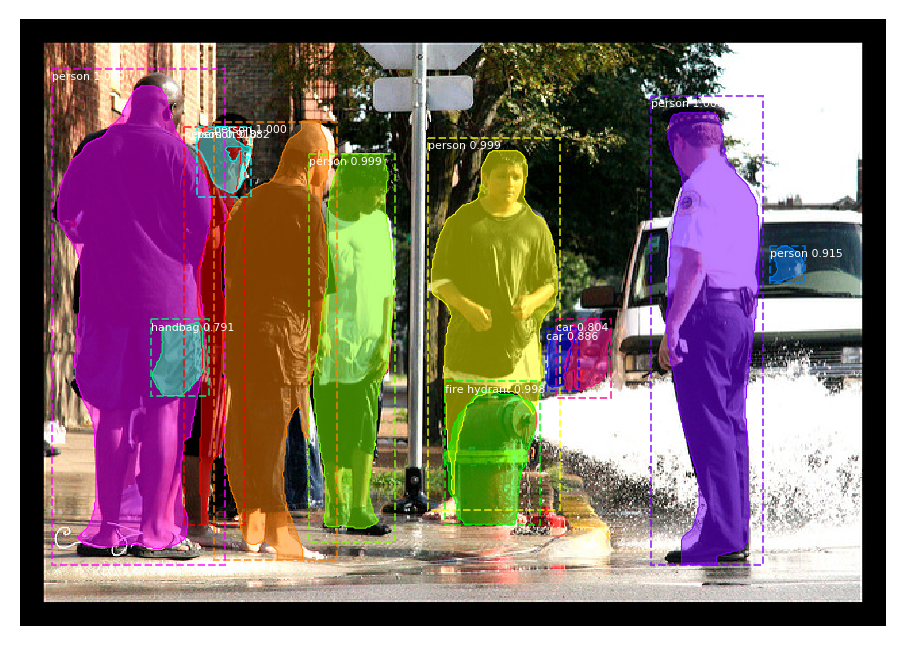

In [73]:
import os
import random

# Load a random image from the images folder
image_folder = 'maskrcnn/images'
file_names = next(os.walk(image_folder))[2]
image = imread(os.path.join(image_folder, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])